In [120]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from pytorchcv.model_provider import get_model as ptcv_get_model # model
import sys, os
import easydict
import torch.backends.cudnn as cudnn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import matplotlib.pyplot as plt
#%matplotlib inline 

# enable cuda devices
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from meta_neural_network_architectures import VGGReLUNormNetwork, ResNet12
from utils.parser_utils import get_args
from data import MetaLearningSystemDataLoader
from experiment_builder import ExperimentBuilder
from utils import basic
from few_shot_learning_system import MAMLFewShotClassifier
import prompters
import torchvision.transforms as T

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
# 시각화 하기 위한 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# 1. Dataset 구성

In [122]:
# choices=['padding', 'random_patch', 'fixed_patch'],
method = 'padding'

os.environ['DATASET_DIR'] = 'C:/Users/JM/PycharmProjects/MAML/datasets'
# os.environ['TEST_DATASET'] = "tiered_imagenet" 
# os.environ['TEST_DATASET'] = "CIFAR_FS" 
# os.environ['TEST_DATASET'] = "CUB" 

In [123]:
os.environ['DATASET_DIR'] = 'C:/Users/JM/PycharmProjects/MAML/datasets'
print("os.environ['DATASET_DIR'] === ", os.environ['DATASET_DIR'])

args = easydict.EasyDict(
{
  "batch_size":2,
  "image_height":84,
  "image_width":84,
  "image_channels":3,
  "gpu_to_use":0,
  "num_dataprovider_workers":4,
  "max_models_to_save":5,
  "dataset_name":"mini_imagenet_full_size",
  "dataset_path":"mini_imagenet_full_size",
  "reset_stored_paths":False,
  "experiment_name":"../MAML_Prompt_padding_5way_5shot_filter64_miniImagenet",
  "train_seed": 0, "val_seed": 0,
  "indexes_of_folders_indicating_class": [-3, -2],
  "sets_are_pre_split": True,
  "train_val_test_split": [0.64, 0.16, 0.20],
  "evaluate_on_test_set_only": False,

  "total_epochs": 100,
  "total_iter_per_epoch":500, "continue_from_epoch": -2,
  "num_evaluation_tasks":600,
  "multi_step_loss_num_epochs": 15,
  "minimum_per_task_contribution": 0.01,
  "learnable_per_layer_per_step_inner_loop_learning_rate": True,
  "enable_inner_loop_optimizable_bn_params": False,
  "evalute_on_test_set_only": False,

  "max_pooling": True,
  "per_step_bn_statistics": False,
  "learnable_batch_norm_momentum": False,
  "load_into_memory": False,
  "init_inner_loop_learning_rate": 0.01,
  "init_inner_loop_weight_decay": 0.0005,
  "learnable_bn_gamma": True,
  "learnable_bn_beta": True,

  "dropout_rate_value":0.0,
  "min_learning_rate":0.001,
  "meta_learning_rate":0.001,   "total_epochs_before_pause": 100,
  "first_order_to_second_order_epoch":-1,
  "weight_decay": 0.0,

  "norm_layer":"batch_norm",
  "cnn_num_filters":64,
  "num_stages":4,
  "conv_padding": True,
  "number_of_training_steps_per_iter":5,
  "number_of_evaluation_steps_per_iter":5,
  "cnn_blocks_per_stage":1,
  "num_classes_per_set":5,
  "num_samples_per_class":5,
  "num_target_samples": 15,
  "samples_per_iter" : 1,

  "second_order": True,
  "use_multi_step_loss_optimization":False,
  "backbone": "4-CONV",
  "arbiter": False,
  "use_bias": True,
  "prompter": True,
  "prompt_engineering": method,
  "prompt_size" : 5,
  "image_size" : 84,
  "prompt_random_init": False,
  "outer_prompt_learning_rate": 0.001,
  "inner_prompt_learning_rate": 0.01
}
)

device = torch.cuda.current_device()
args.im_shape = (2, 3, args.image_height, args.image_width)

args.use_cuda = torch.cuda.is_available()
args.seed = 104
args.reverse_channels=False
args.labels_as_int=False
args.reset_stored_filepaths=False
args.num_of_gpus=1

args.continue_from_epoch='latest'

os.environ['DATASET_DIR'] ===  C:/Users/JM/PycharmProjects/MAML/datasets


# 2. 모델 구성

In [124]:
# 모델을 구성한다
model = MAMLFewShotClassifier(args=args, device=device,
                              im_shape=(2, 3,
                                        args.image_height, args.image_width))

data = MetaLearningSystemDataLoader

maml_system = ExperimentBuilder(model=model, data=data, args=args, device=device)
# maml_system.state

Using max pooling
meta network params
0.01
Inner Loop parameters
prompt_learning_rates_dict.prompt-prompt_dict-pad_up torch.Size([6])
prompt_learning_rates_dict.prompt-prompt_dict-pad_down torch.Size([6])
prompt_learning_rates_dict.prompt-prompt_dict-pad_left torch.Size([6])
prompt_learning_rates_dict.prompt-prompt_dict-pad_right torch.Size([6])
names_learning_rates_dict.layer_dict-linear-weights torch.Size([6])
names_learning_rates_dict.layer_dict-linear-bias torch.Size([6])
Outer Loop parameters
classifier.prompt.prompt_dict.pad_up torch.Size([3, 5, 84]) cuda:0 True
classifier.prompt.prompt_dict.pad_down torch.Size([3, 5, 84]) cuda:0 True
classifier.prompt.prompt_dict.pad_left torch.Size([3, 74, 5]) cuda:0 True
classifier.prompt.prompt_dict.pad_right torch.Size([3, 74, 5]) cuda:0 True
classifier.layer_dict.conv0.conv.weight torch.Size([64, 3, 3, 3]) cuda:0 True
classifier.layer_dict.conv0.conv.bias torch.Size([64]) cuda:0 True
classifier.layer_dict.conv0.norm_layer.bias torch.Size([6

# 3. 가우시안 커널 계산

## 3-1 먼저 training task에 대한 centroid를 저장한다

In [125]:
# train_data = maml_system.data.get_train_batches(total_batches=int(600/1), augment_images=False)
train_data = maml_system.data.get_train_batches(total_batches=2, augment_images=False)

print("==> Extract training task feature vector:")

count = 0
trained_vector = torch.FloatTensor().cuda()

for sample_idx, train_sample in enumerate(train_data):
    
    x_support_set, x_target_set, y_support_set, y_target_set, seed = train_sample
    
    x_support_set = torch.Tensor(x_support_set).float().to(device=maml_system.model.device)
    x_target_set = torch.Tensor(x_target_set).float().to(device=maml_system.model.device)
    y_support_set = torch.Tensor(y_support_set).long().to(device=maml_system.model.device)
    y_target_set = torch.Tensor(y_target_set).long().to(device=maml_system.model.device)
    
    for task_id, (x_support_set_task, y_support_set_task, x_target_set_task, y_target_set_task) in enumerate(zip(x_support_set,
                              y_support_set,
                              x_target_set,
                              y_target_set)):
        
        
        names_weights_copy = maml_system.model.get_inner_loop_parameter_dict(maml_system.model.classifier.named_parameters())

        num_devices = torch.cuda.device_count() if torch.cuda.is_available() else 1

        names_weights_copy = {
                name.replace('module.', ''): value.unsqueeze(0).repeat(
                    [num_devices] + [1 for i in range(len(value.shape))]) for
                name, value in names_weights_copy.items()}

        prompted_weights_copy = {}
        if args.prompter:
            prompted_weights_copy = {key: value for key, value in names_weights_copy.items() if 'prompt' in key}

        names_weights_copy = {key: value for key, value in names_weights_copy.items() if 'layer_dict' in key}
        
        
        n, s, c, h, w = x_target_set_task.shape

        x_support_set_task = x_support_set_task.view(-1, c, h, w)
        y_support_set_task = y_support_set_task.view(-1)
        x_target_set_task = x_target_set_task.view(-1, c, h, w)
        y_target_set_task = y_target_set_task.view(-1)
        
        
        for num_step in range(5):

            support_loss, support_preds, _ = maml_system.model.net_forward_feature_extractor(
              x=x_support_set_task,
              y=y_support_set_task,
              weights=names_weights_copy,
              prompted_weights=prompted_weights_copy,
              backup_running_statistics=num_step == 0,
              training=True,
              num_step=num_step,
              training_phase=False,
              epoch=0)
            
            names_weights_copy, prompted_weights_copy = maml_system.model.apply_inner_loop_update(
             loss=support_loss,
             names_weights_copy=names_weights_copy,
             prompted_weights_copy=prompted_weights_copy,
             use_second_order=True,
             current_step_idx=num_step,
             current_iter='test',
             training_phase=False)
            
            if num_step == 4:
                count = count + 1
                print("count == ", count)
                target_loss, target_preds, feature_map_list = maml_system.model.net_forward_feature_extractor(
                    x=x_target_set_task,
                    y=y_target_set_task,
                    weights=names_weights_copy,
                    prompted_weights=prompted_weights_copy,
                    backup_running_statistics=False, training=True,
                    num_step=num_step,
                    training_phase=False,
                    epoch=0)

                query_feature_map = feature_map_list[3].detach()
                task_feature = torch.mean(query_feature_map, dim=0).unsqueeze(dim=0)
                trained_vector = torch.cat((trained_vector, task_feature), dim=0)

print("...DONE\n")

==> Extract training task feature vector:


C:\Users\JM\PycharmProjects\prompt_maml\meta_neural_network_architectures.py:988: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen/core/TensorBody.h:485.)
  if param.grad is not None:


count ==  1
count ==  2
count ==  3
count ==  4
...DONE



In [126]:
print(trained_vector.shape)

torch.Size([4, 64, 5, 5])


## 3-2 test tasks에 대한 centroid를 저장한다

In [127]:
test_data = maml_system.data.get_test_batches(total_batches=20, augment_images=False)

print("==> Extract test task feature vector:")

count = 0
test_vector = torch.FloatTensor().cuda()

for sample_idx, train_sample in enumerate(test_data):
    
    x_support_set, x_target_set, y_support_set, y_target_set, seed = train_sample
    
    x_support_set = torch.Tensor(x_support_set).float().to(device=maml_system.model.device)
    x_target_set = torch.Tensor(x_target_set).float().to(device=maml_system.model.device)
    y_support_set = torch.Tensor(y_support_set).long().to(device=maml_system.model.device)
    y_target_set = torch.Tensor(y_target_set).long().to(device=maml_system.model.device)
    
    for task_id, (x_support_set_task, y_support_set_task, x_target_set_task, y_target_set_task) in enumerate(zip(x_support_set,
                              y_support_set,
                              x_target_set,
                              y_target_set)):
        
        
        names_weights_copy = maml_system.model.get_inner_loop_parameter_dict(maml_system.model.classifier.named_parameters())

        num_devices = torch.cuda.device_count() if torch.cuda.is_available() else 1

        names_weights_copy = {
                name.replace('module.', ''): value.unsqueeze(0).repeat(
                    [num_devices] + [1 for i in range(len(value.shape))]) for
                name, value in names_weights_copy.items()}

        prompted_weights_copy = {}
        if args.prompter:
            prompted_weights_copy = {key: value for key, value in names_weights_copy.items() if 'prompt' in key}

        names_weights_copy = {key: value for key, value in names_weights_copy.items() if 'layer_dict' in key}
        
        
        n, s, c, h, w = x_target_set_task.shape

        x_support_set_task = x_support_set_task.view(-1, c, h, w)
        y_support_set_task = y_support_set_task.view(-1)
        x_target_set_task = x_target_set_task.view(-1, c, h, w)
        y_target_set_task = y_target_set_task.view(-1)
        
        
        for num_step in range(5):

            support_loss, support_preds, _ = maml_system.model.net_forward_feature_extractor(
              x=x_support_set_task,
              y=y_support_set_task,
              weights=names_weights_copy,
              prompted_weights=prompted_weights_copy,
              backup_running_statistics=num_step == 0,
              training=True,
              num_step=num_step,
              training_phase=False,
              epoch=0)
            
            names_weights_copy, prompted_weights_copy = maml_system.model.apply_inner_loop_update(
             loss=support_loss,
             names_weights_copy=names_weights_copy,
             prompted_weights_copy=prompted_weights_copy,
             use_second_order=True,
             current_step_idx=num_step,
             current_iter='test',
             training_phase=False)
            
            if num_step == 4:
                
                count = count + 1
                print("count == ", count)
                                
                target_loss, target_preds, feature_map_list = maml_system.model.net_forward_feature_extractor(
                    x=x_target_set_task,
                    y=y_target_set_task,
                    weights=names_weights_copy,
                    prompted_weights=prompted_weights_copy,
                    backup_running_statistics=False, training=True,
                    num_step=num_step,
                    training_phase=False,
                    epoch=0)

                query_feature_map = feature_map_list[3].detach()
                task_feature = torch.mean(query_feature_map, dim=0).unsqueeze(dim=0)
                test_vector = torch.cat((test_vector, task_feature), dim=0)

print("...DONE\n")

==> Extract test task feature vector:
count ==  1
count ==  2
count ==  3
count ==  4
count ==  5
count ==  6
count ==  7
count ==  8
count ==  9
count ==  10
count ==  11
count ==  12
count ==  13
count ==  14
count ==  15
count ==  16
count ==  17
count ==  18
count ==  19
count ==  20
count ==  21
count ==  22
count ==  23
count ==  24
count ==  25
count ==  26
count ==  27
count ==  28
count ==  29
count ==  30
count ==  31
count ==  32
count ==  33
count ==  34
count ==  35
count ==  36
count ==  37
count ==  38
count ==  39
count ==  40
...DONE



In [128]:
print(test_vector.shape)

torch.Size([40, 64, 5, 5])


# 4. Computing Euclidean distance

In [129]:
# training

gap = nn.AdaptiveAvgPool2d((1, 1))

# Step 1: GAP → (B, 64, 1, 1) → view → (B, 64)
batch_size = trained_vector.shape[0]
trained_vector_gap = gap(trained_vector)              # shape: (B, 64, 1, 1)
trained_vectorr_flat = trained_vector_gap.view(batch_size, 64)  # shape: (B, 64)

# Step 2: Normalize test vector
normalized_trained_vector = torch.nn.functional.normalize(trained_vectorr_flat)

In [130]:
# test

gap = nn.AdaptiveAvgPool2d((1, 1))

# Step 1: GAP → (B, 64, 1, 1) → view → (B, 64)
batch_size = test_vector.shape[0]
test_vector_gap = gap(test_vector)              # shape: (B, 64, 1, 1)
test_vector_flat = test_vector_gap.view(batch_size, 64)  # shape: (B, 64)

# Step 2: Normalize test vector
normalized_test_vector = torch.nn.functional.normalize(test_vector_flat)

In [131]:
distance = torch.empty(0).cuda()

for i in range(len(normalized_trained_vector)):
    dist = torch.cdist(
        normalized_trained_vector[0].unsqueeze(0),  # shape: (1, 64)
        normalized_test_vector[i].unsqueeze(0)      # shape: (1, 64)
    )  # result: shape (1, 1)
    
    distance = torch.cat((distance, dist.view(1)), dim=0)  # flatten & accumulate

print(distance.shape)  # (B,

torch.Size([4])


C:\Users\JM\anaconda3\envs\maml\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  """


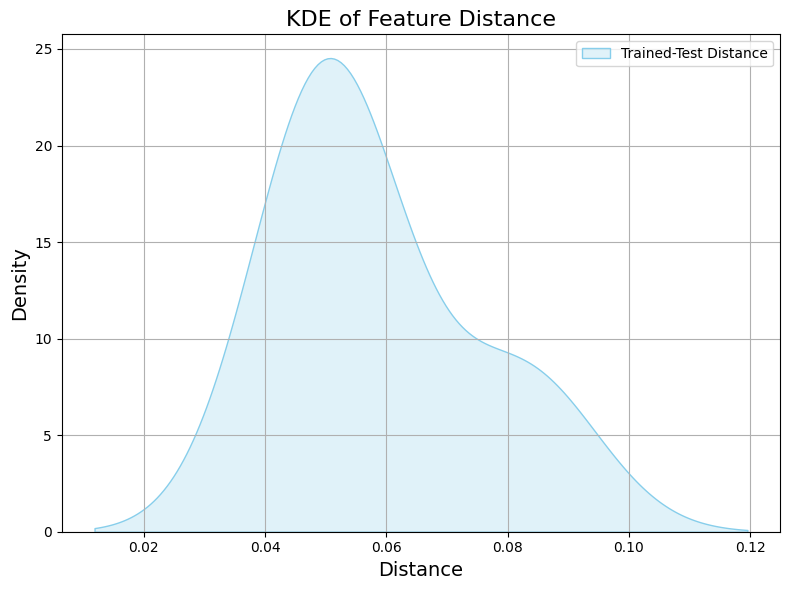

In [132]:
distance_np = distance.detach().cpu().numpy()
np.save("metapro_distance.npy", distance_np)

plt.figure(figsize=(8, 6))
sns.kdeplot(distance_np, shade=True, color="skyblue", label="Trained-Test Distance")
plt.xlabel("Distance", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.title("KDE of Feature Distance", fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
